## Introduction

### In this notebook we use [DeepLabV3+](https://arxiv.org/abs/1802.02611) for Land Cover Classfication from Satellite Imagery using [DeepGlobe Land Cover Classification Dataset](https://www.kaggle.com/balraj98/deepglobe-land-cover-classification-dataset).

### Libraries 📚⬇

In [13]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [14]:
# !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Read Data & Create train / valid splits 📁

In [15]:
# DATA_DIR = '../input/deepglobe-land-cover-classification-dataset'
DATA_DIR = 'data/deepglobe'

import os
import pandas as pd

# Set the path to your image directory relative to the project directory
image_directory = "data/merge"

# Initialize lists to store data
image_ids = []
sat_image_paths = []
mask_paths = []

# Iterate through files in the directory
for filename in os.listdir(image_directory):
    # Check if the file is a satellite image (jpg)
    if filename.endswith(".jpg"):
        image_id = os.path.splitext(filename)[0]
        sat_image_path = os.path.join(image_directory, filename)

        # Check if the corresponding mask (png) exists
        mask_filename = f"{image_id}_m.png"
        mask_path = os.path.join(image_directory, mask_filename)

        if os.path.exists(mask_path):
            # Append data to lists
            image_ids.append(image_id)
            sat_image_paths.append(sat_image_path)
            mask_paths.append(mask_path)

# Create a DataFrame
data = {
    'image_id': image_ids,
    'sat_image_path': sat_image_paths,
    'mask_path': mask_paths
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

metadata_df = df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)


                image_id                      sat_image_path  \
0      M-33-20-D-c-4-2_0    data/merge\M-33-20-D-c-4-2_0.jpg   
1      M-33-20-D-c-4-2_1    data/merge\M-33-20-D-c-4-2_1.jpg   
2     M-33-20-D-c-4-2_10   data/merge\M-33-20-D-c-4-2_10.jpg   
3    M-33-20-D-c-4-2_100  data/merge\M-33-20-D-c-4-2_100.jpg   
4    M-33-20-D-c-4-2_101  data/merge\M-33-20-D-c-4-2_101.jpg   
..                   ...                                 ...   
164   M-33-7-A-d-3-2_109   data/merge\M-33-7-A-d-3-2_109.jpg   
165   M-33-7-A-d-3-2_110   data/merge\M-33-7-A-d-3-2_110.jpg   
166   M-33-7-A-d-3-2_111   data/merge\M-33-7-A-d-3-2_111.jpg   
167     M-33-7-A-d-3-2_5     data/merge\M-33-7-A-d-3-2_5.jpg   
168     M-33-7-A-d-3-2_6     data/merge\M-33-7-A-d-3-2_6.jpg   

                                mask_path  
0      data/merge\M-33-20-D-c-4-2_0_m.png  
1      data/merge\M-33-20-D-c-4-2_1_m.png  
2     data/merge\M-33-20-D-c-4-2_10_m.png  
3    data/merge\M-33-20-D-c-4-2_100_m.png  
4    data/m

(152, 17)

In [16]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


#### Shortlist specific classes to segment

In [17]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


### Helper functions for viz. & one-hot encoding/decoding

In [18]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [19]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

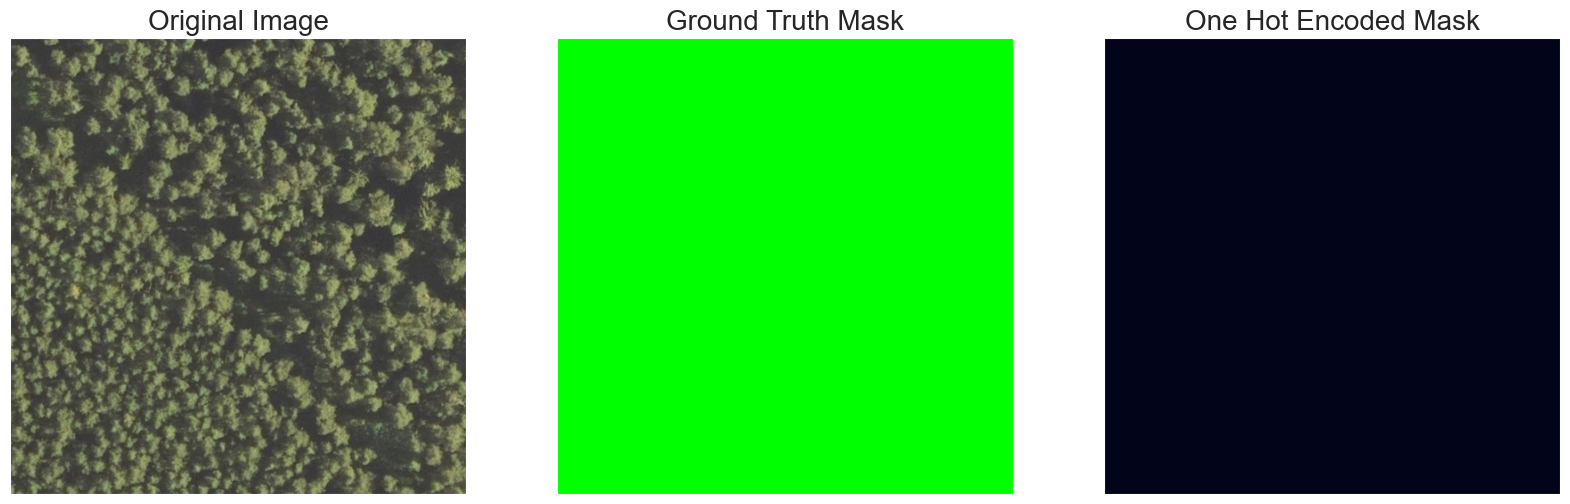

In [20]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [21]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

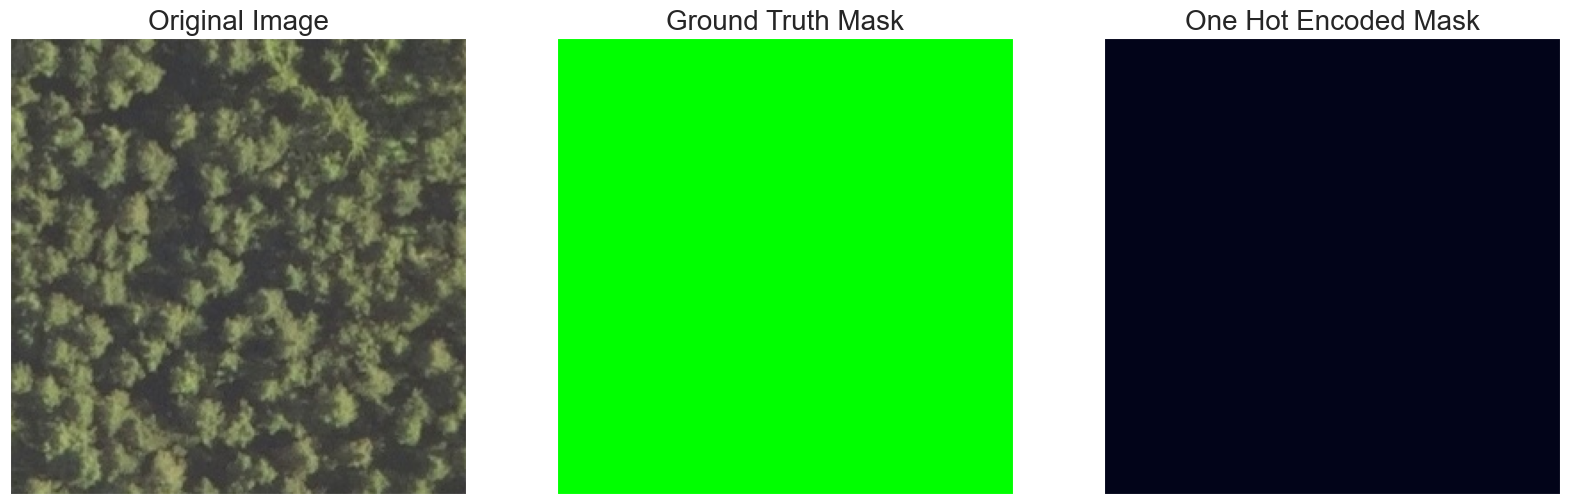

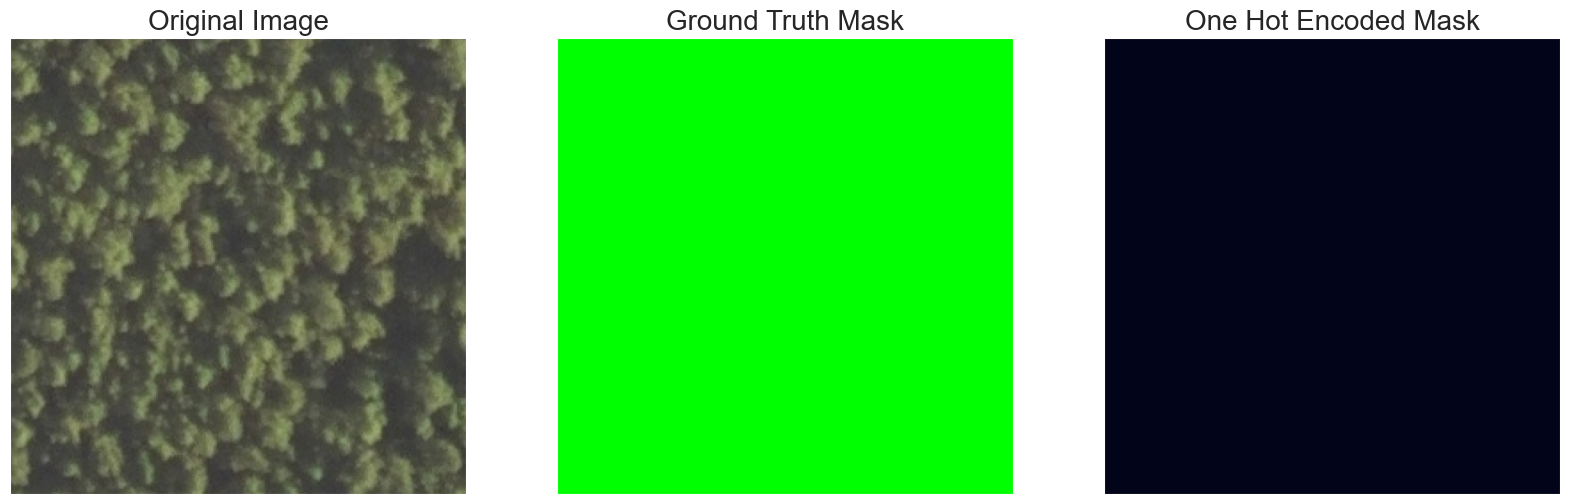

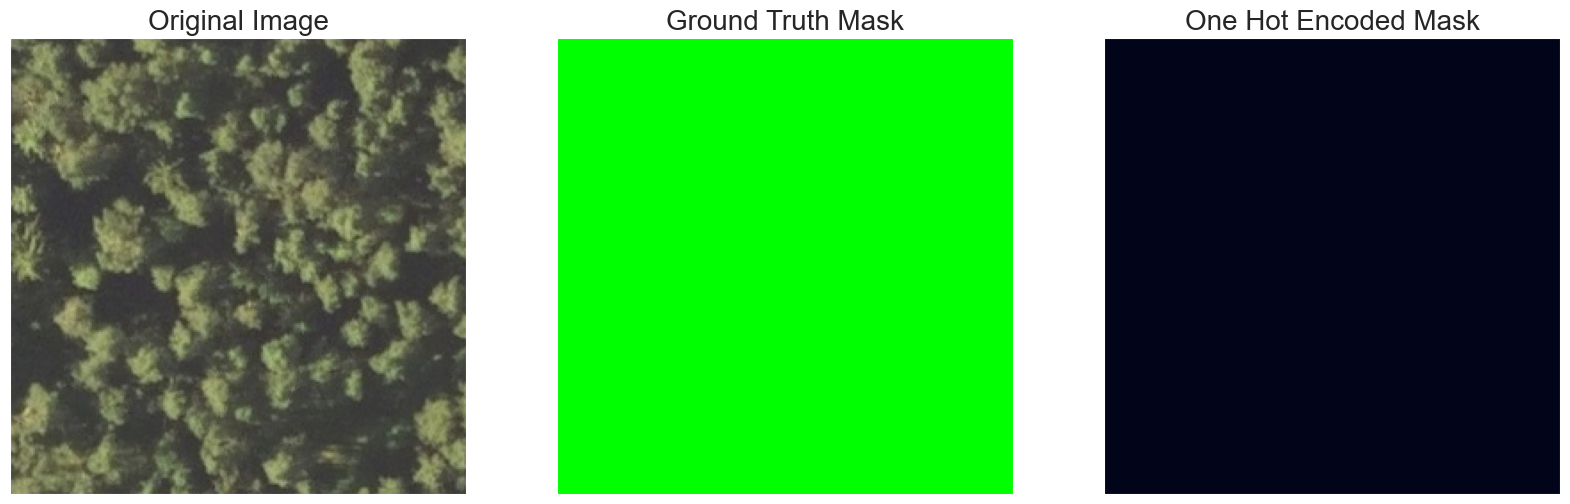

In [22]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training DeepLabV3+

<h3><center>DeepLabV3+ Model Architecture</center></h3>
<img src="https://miro.medium.com/max/1000/1*2mYfKnsX1IqCCSItxpXSGA.png" width="750" height="750"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/abs/1802.02611">Image Source: DeepLabV3+ [Liang-Chieh Chen et al.]</a></center></h4>

### Model Definition

In [23]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [24]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

SyntaxError: invalid syntax (3308731527.py, line 14)

#### Set Hyperparams

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
import segmentation_models_pytorch.utils.metrics
TRAINING = True

# Set num of epochs
EPOCHS = 5
# EPOCHS = 1

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training DeepLabV3+

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        print('\n TESTA')
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
best_model = model

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_urban_land_heatmap = pred_urban_land_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()